<a href="https://colab.research.google.com/github/ajayrfhp/LearningDeepLearning/blob/main/DistributedTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal
- Understand how distributed training works and improve the efficiency

### Why do we need distributed training ?
- Models are getting larger. Training takes a long time.
  - NVIDIA A 100 provides 312TFLOPS at FP16 and 19.5 TFLOPS at FP32
- Developer / researcher time is more valuable than hardware.
  - If training takes 10 GPU days, TotalWorkDone = WorkDonePerSec * 10 * 86400
  - If we have 1024 GPUs, TimeTakenInMinutes = WorkDonePerSec * 10 * 86400 / (1024 * 60) = 14


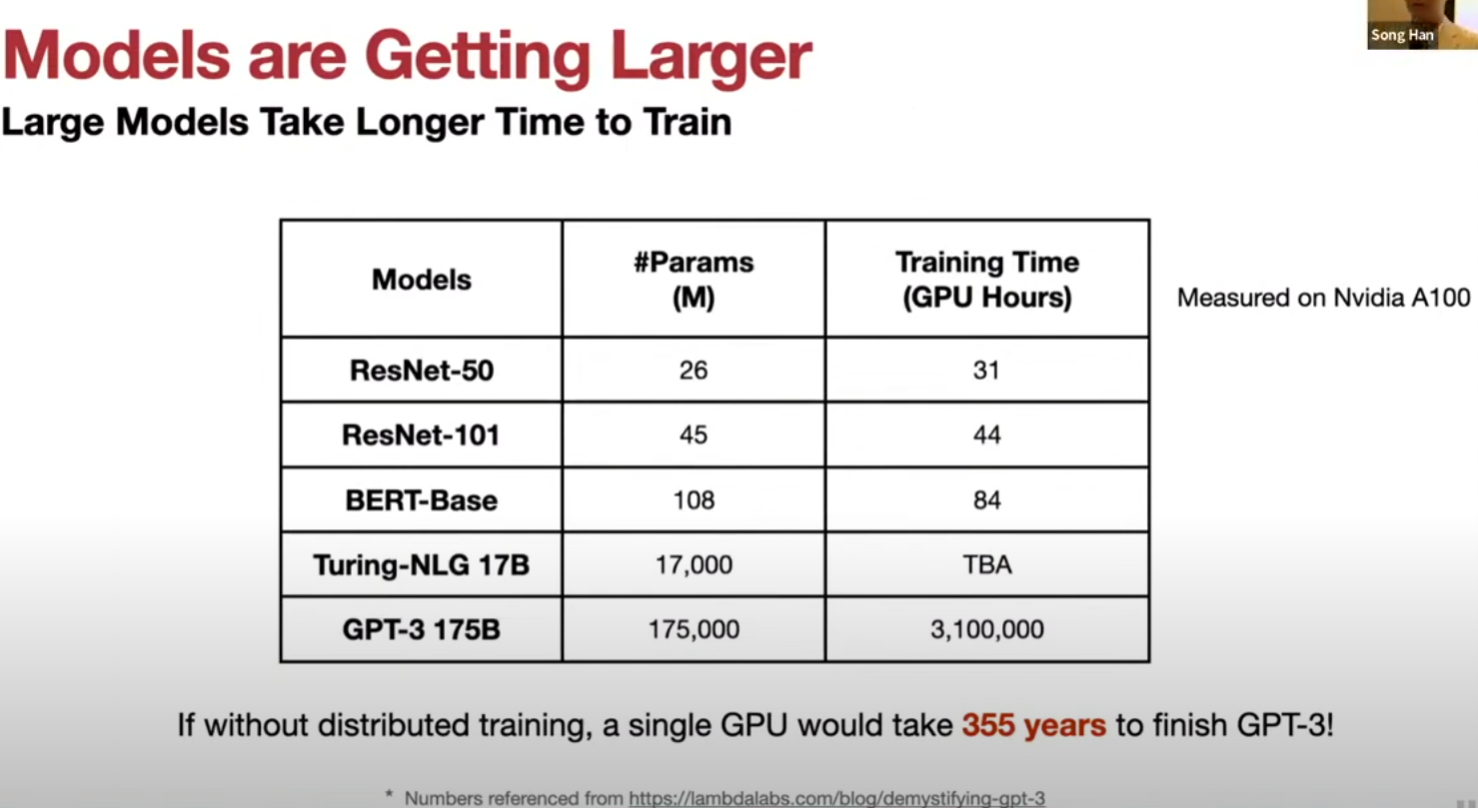

#### Example
- TSM video model needs to be trained on 660 hours of videos.
- With 6 GPUs, it takes ~50h, with 768 GPUs, its down to 28 minutes and with 1500 GPUs, its down to 15 minutes.

## Data parallelism

### nn.DataParallel vs nn.DistributedDataParallel
- nn.Parallel uses multi threaded process to distribute data across GPUs. There is a central server which handles the coordination. This is inefficient because the python interpretter executes one thread at a time. So this offers limited parallelizing power. 
    - Scatter minibatch data across GPUs, replicate model from master to other GPUs, run forward pass on each gpu parallely, gather output on master gpu, compute loss, scatter loss, compute gradients on edge nodes, reduce gradients on master, update model parameters
    - Extra data copy, from disk to master GPU, then distributed across GPUs. 
    - Uneven GPU usage, loss calculation on master, forward, backward pass on other GPUs. 
- nn.DistributedDataParallel spins off seperate processes in different GPUs, no central server. DistributedSampler ensures non-overlapping data is fed to all systems. 
    - Has multiple processes, each gpu has identical copy of model, no need to copy model across GPUs
        - Spread data across gpus from disk, run forward pass, get loss, run backward pass, get gradients, perform gradient all reduce. Gradient communication is done parallel with gradient computation. No model sync is needed. 
        - Gradients of layer L is independent of gradients of layer L-1, thus once gradients of L is computed, GPU can begin transmission of layer L to other GPUs, and can move onto computing layer L-1. All GPUs wait together in the end. 
- Example
    - Gradient computation is 1 sec, communication is 0.5 seconds. 
    - If we have 10 layers, doing gradient computation first, communicating later is going to take 15 seconds. 
    - If we can interleave 9 communication with gradient computation, then it will take 9 + 1 + 0.5 = 10.5. The communication cost of 9 layers is now cut because of overlap. 

Without Pipelining:
```
Time   |  Computation          |  Communication
-------|----------------------|------------------
0-10   |  Compute all grads   |  -
10-15  |  -                   |  All-reduce all
15     |  Update parameters   |  -
```
Total time: 15 units

With Pipelining:
```
Time   |  Computation          |  Communication
-------|----------------------|------------------
0-1    |  Compute Layer10 grad|  -
1-2    |  Compute Layer9 grad |  All-reduce Layer10
2-3    |  Compute Layer8 grad |  All-reduce Layer9
3-4    |  Compute Layer7 grad |  All-reduce Layer8
4-5    |  Compute Layer6 grad |  All-reduce Layer7
5-6    |  Compute Layer5 grad |  All-reduce Layer6
6-7    |  Compute Layer4 grad |  All-reduce Layer5
7-8    |  Compute Layer3 grad |  All-reduce Layer4
8-9    |  Compute Layer2 grad |  All-reduce Layer3
9-10   |  Compute Layer1 grad |  All-reduce Layer2
10-10.5|  -                   |  All-reduce Layer1
10.5   |  Update parameters   |  -
```
Total time: 10.5 units

### Data parallelism

- In data parallelism, data is sent to different GPUs.
- Same model is used across devices
- Parameter server controls the whole training process. Receieves gradients from workers and send back aggregated results
  1. Replicate and pull
    - Replicates copy of model onto every worker CPU
    - Broadcast communication primitive is used. Identical weight is sent to all worker nodes. Bandwidth cost is O(N) on parameter server.
  5. Update model weights
    - Gradients are aggregated, weights are updated.
    - Reduce communication primitive is used to average gradients from all workers. Bandwidth cost is O(N) on parameter server.
- Workers compute gradients using spllited dataset and send to parameter server.
  2. Randomly spread dataset over GPUs
  3. Compute gradient
    - Each GPU computes gradients independently
  4. Push and sum
    - Each GPU does a push & Sum to push gradients to server.

- Compared to a single node training, distributed training has 2 extra steps for synchronization.  To replicate model from central server and push gradients back to central server. Gradient update step is performed at parameter server after aggregation.






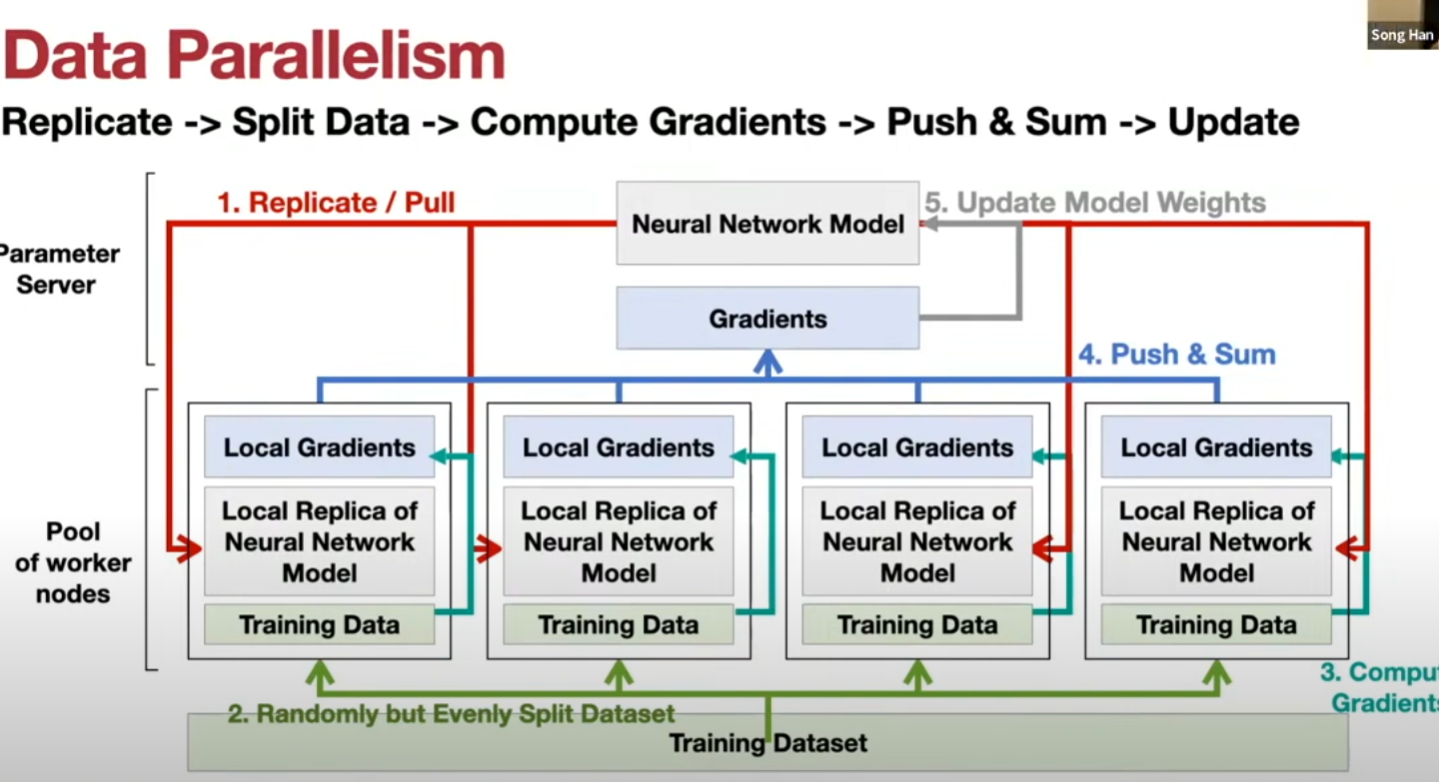

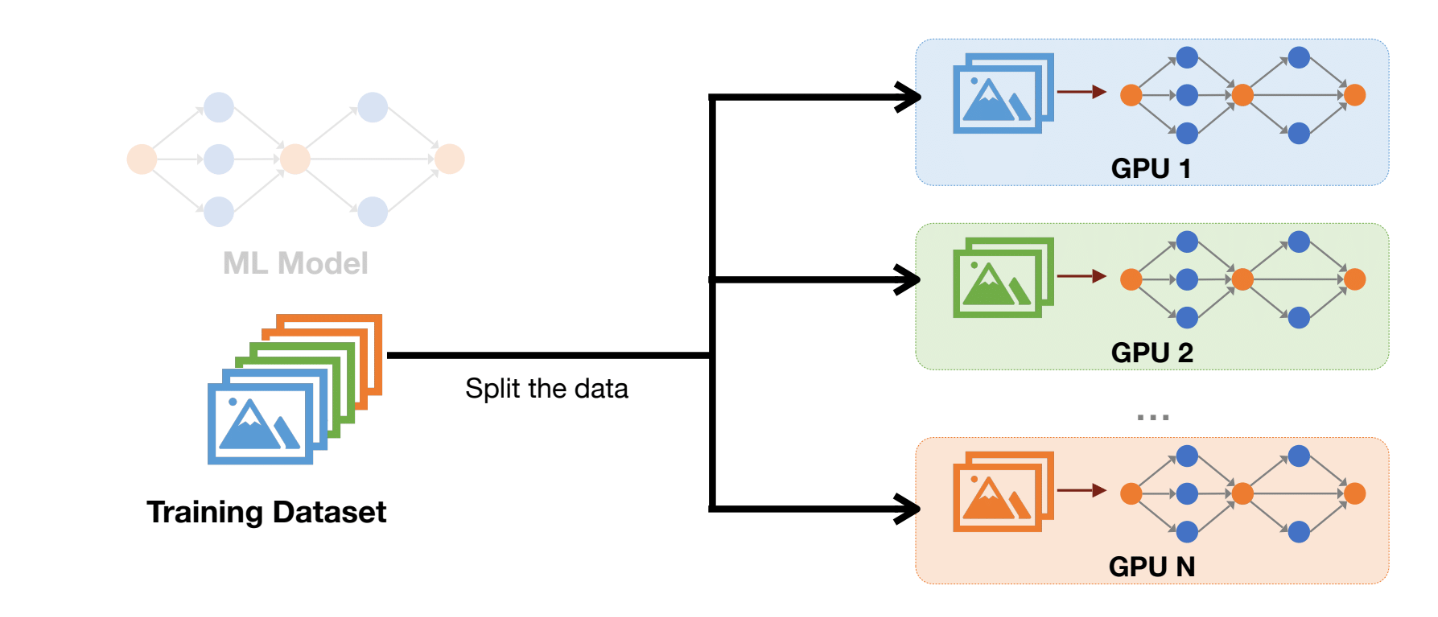

#### Can we do data parallelism without a central server ?
- Naive all reduce
  - Every node does a new reduce
  - Memory bandwidth is O(N) and time is O(N)
- Ring all reduce
  - Only communicate with your direct neighbor
  - Memory bandwith is O(1) and time is O(N)
- All reduce Parallel
  - Exchange info with neighor, then offset 2, offset 4 etc.
  - Info exchange in O(logN) steps. Memory bandwidth is O(1)


- Modern LLMs can't even fit inside a single GPU
  - 175B parameter with fp 16(2 bytes) needs 350 GB in memory

### Model parallelism
- Each layer of model lives in different GPU, GPU idle time high.

### Tensor parallalism
- Split the tensor horizontally. Half neurons of a layer in GPU1, rest in GPU 2 etc. 

### Pipeline parallelism
- Model parallelism + data parallelism

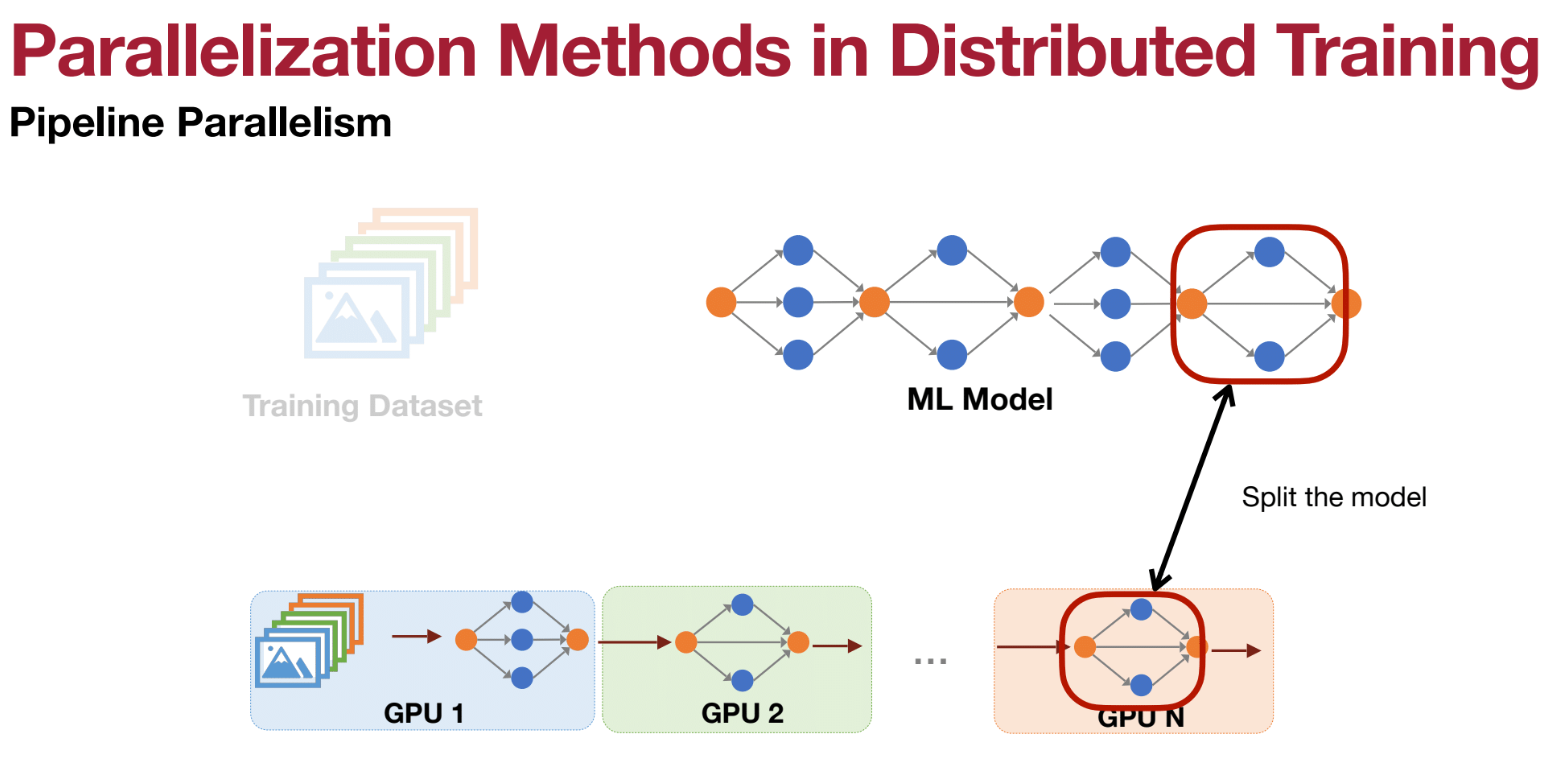

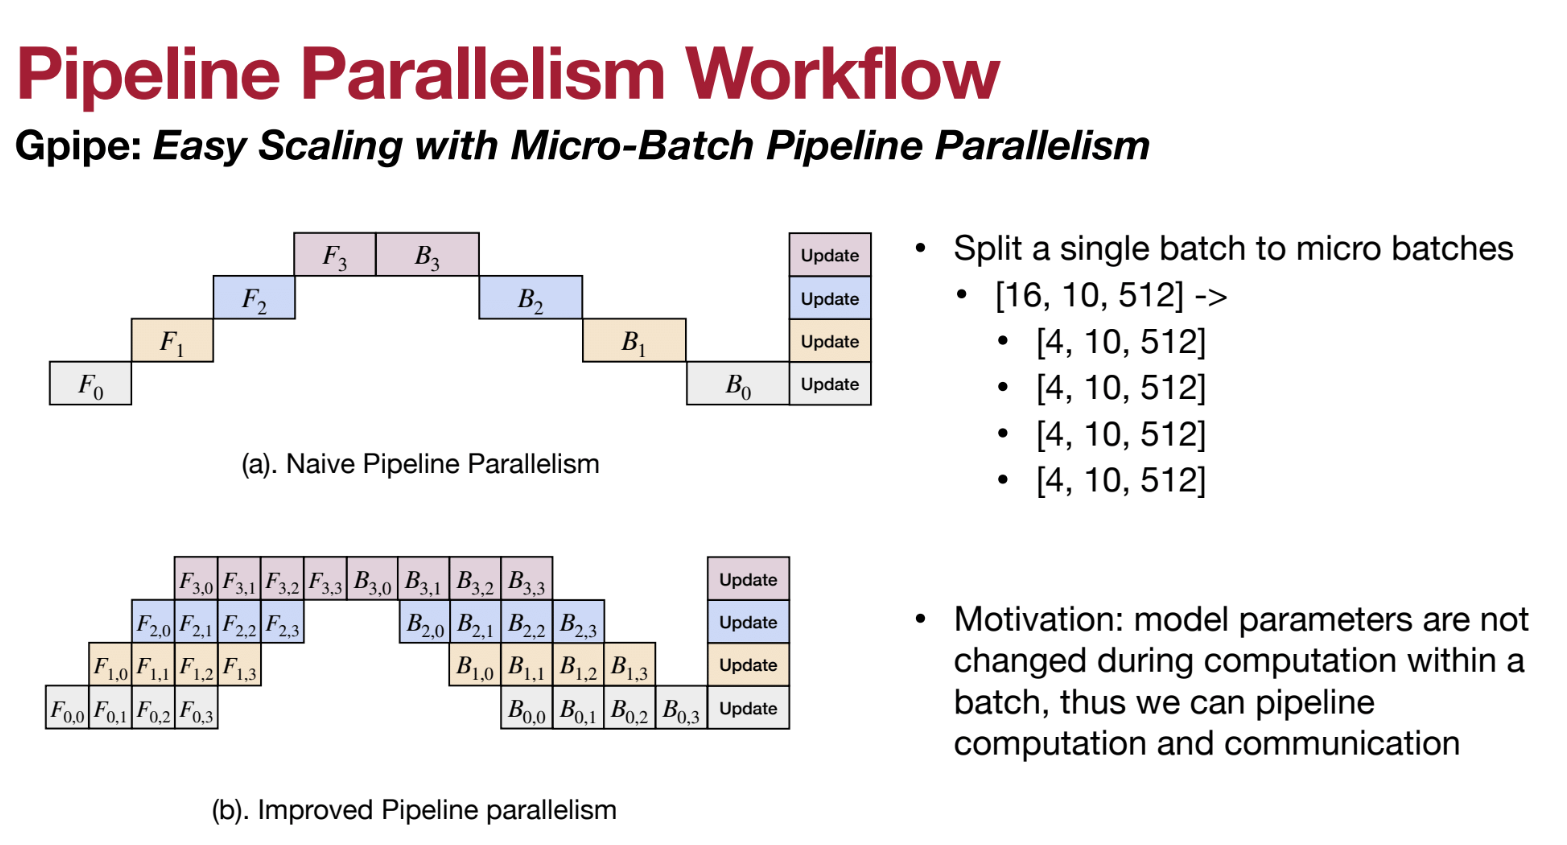

### Large batch training hacks
#### Learning rate warmup
- Gradually increase learning rates, allows model to adapt to data. Provides early stage stability. 

#### LARS
- Optimization algorithm that gives each layer seperate learning rates based on ratio of weight norm to gradient norm. 
- Layer wise adapatation, each layer gets seperate learning rate
- Uses momentum as base. 

#### LAMB
- LARS + ADAMW
- Each layer gets seperate learning rate with trust ratios, uses adamW. 
- LaMB is based on ADAM. Takes second moment into account

### Pytorch FSDP
- [FSDP explained](https://www.youtube.com/watch?v=By_O0k102PY&t=1542s&ab_channel=AhmedTaha)
- DDP replicates model across all GPUs, this is unnecessary. FSDP shards model, parameters, optimizer states, gradients across GPUs. This allows us to train models which are larger than ones that can fit within any GPU. This is the spirit of deep speed, but FSDP is a native pytorch implementation
- Deep speed 
    - Reduces memory footprint by N where N is number of GPUs, with some increase in communication volume. 

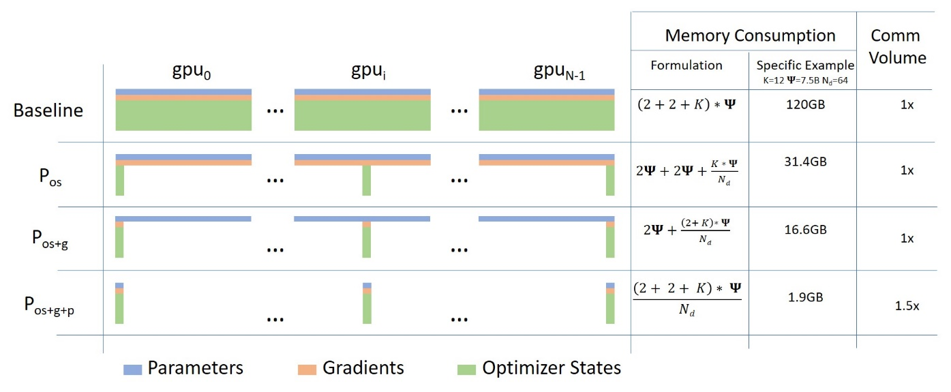

- NCCL primitives
    - All Gather
        - Collect information from all GPUs into a single node
    - All reduce
        - Collect information from all GPUs and aggregate result and store in single node
    - Reduce scatter
        - Collect information all GPUs, aggregate results and scatter results over all GPUs. 
- FSDP unit
    - Unit to split the model
    - A layer or a module defined s.t forward/backward prop for different FSDP units can be computed independently. So execution of each FSDP unit can be parallelized
- Each FSDP unit is distributed across multiple GPUs
- When forward pass is executed for one FSDP unit, all gather is performed to collect all info. Forward pass is performed in all GPUs. Key point is that only one FSDP unit is fully gathered at any one point. 

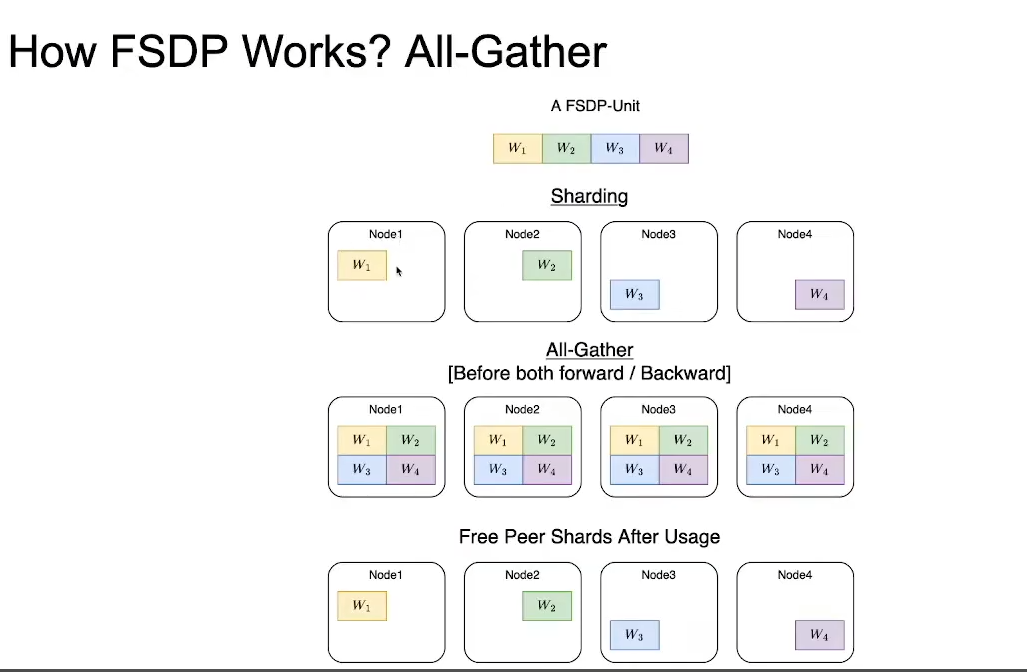

- When doing backward pass, similarly, gradients are collected for one FSDP unit, then reduce-scatter is done to sum gradients and distribute gradients across GPUs.
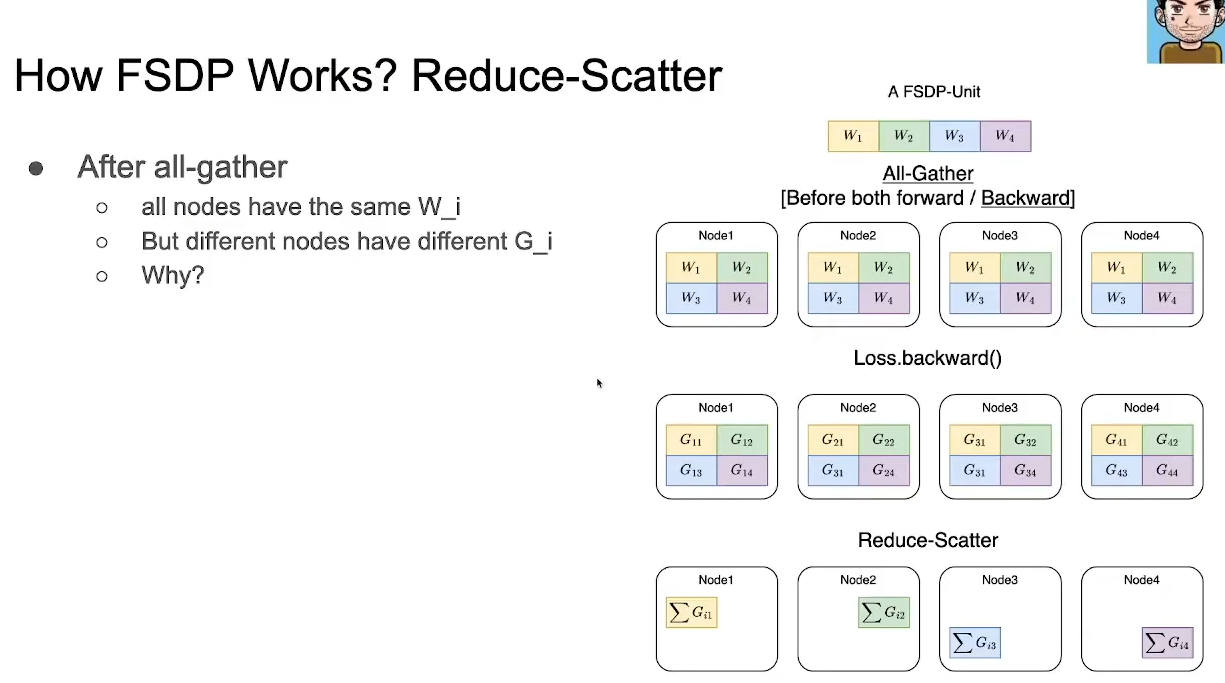

- Maximum memory needed is size of largest FSDP unit materialized + size of model
- Communication / computation overlap is done to ensure computation of one FSDP is done while communication for next FSDP is done. 

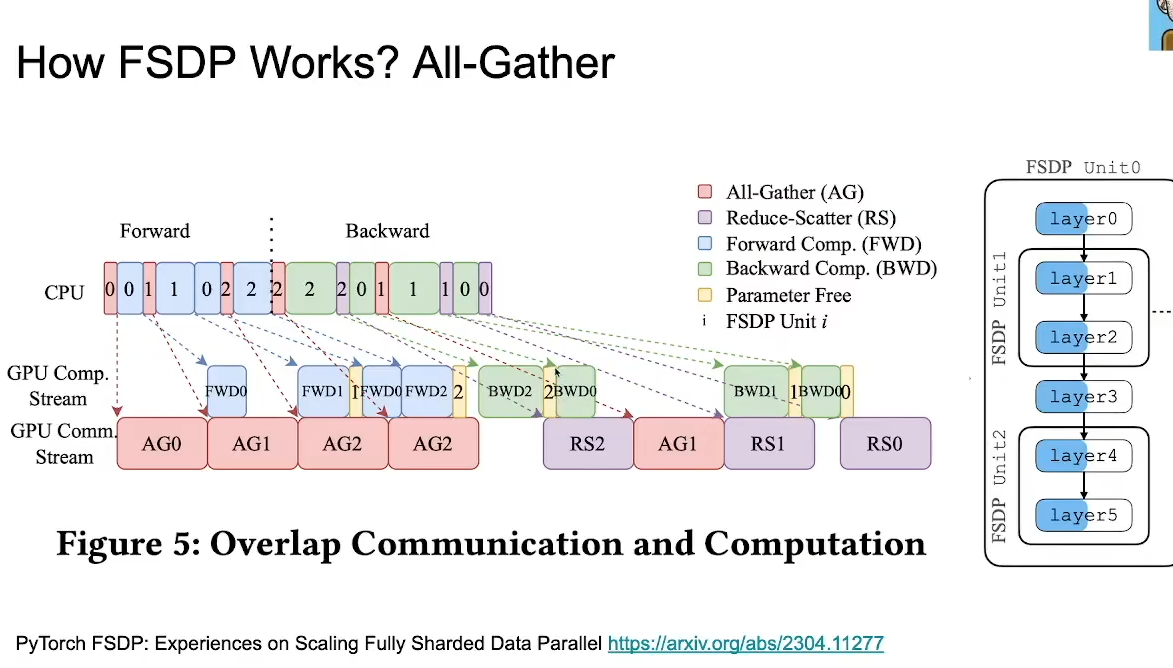

### References
- [Deepspeed](https://www.microsoft.com/en-us/research/blog/zero-deepspeed-new-system-optimizations-enable-training-models-with-over-100-billion-parameters/)
- [FSDP](https://www.youtube.com/watch?v=By_O0k102PY&t=1542s&ab_channel=AhmedTaha)